<a href="https://colab.research.google.com/github/Ali-Alameer/Deep-Learning/blob/main/week6_tensorflowhub_with_your_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow


tf.keras.applications

This workshop demonstrates how to:

1. Use models from TensorFlow with `tf.keras.applications`.
1. Use an image classification model from TensorFlow.
1. Do simple transfer learning to fine-tune a model for your own image classes.

## Setup

In [3]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

## An ImageNet classifier

You'll start by using a classifier model pre-trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) benchmark dataset—no initial training required!

### Download the classifier

Read Docs

[MobileNetV3Large](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Large)
MobileNetV3Large: A lightweight and efficient model suitable for mobile and embedded devices.
<br>
[InceptionV3](https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3)
InceptionV3: A deep neural network architecture known for high accuracy on image classification tasks.

In [94]:
IMAGE_SHAPE = (224, 224)

print("Choose a model:")
print("1. MobileNetV3")
print("2. InceptionV3")

choice = input("Enter your choice (1/2): ")

if choice == "1":
    base_model = tf.keras.applications.MobileNetV3Large(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SHAPE + (3,)
    )
elif choice == "2":
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SHAPE + (3,)
    )
else:
    print("Invalid choice. Defaulting to MobileNetV3.")
    base_model = tf.keras.applications.MobileNetV3Large(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SHAPE + (3,)
    )

classifier = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1000, activation='softmax')
])

base_model.trainable = False

print(f"Using {base_model.name} as the base model with input shape {IMAGE_SHAPE + (3,)}")

Choose a model:
1. MobileNetV3
2. InceptionV3
Enter your choice (1/2): 2
Using inception_v3 as the base model with input shape (224, 224, 3)


### Run it on a single image

Download a single image to try the model on:

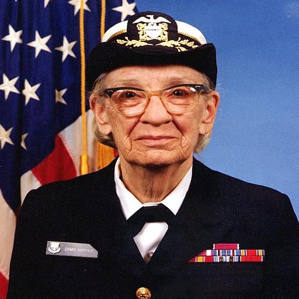

In [70]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [71]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(299, 299, 3)

Add a batch dimension (with `np.newaxis`) and pass the image to the model:

In [72]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


(1, 1000)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with `tf.math.argmax`:

In [73]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=749>

### Decode the predictions

Take the `predicted_class` ID (such as `653`) and fetch the ImageNet dataset labels to decode the predictions:

In [74]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

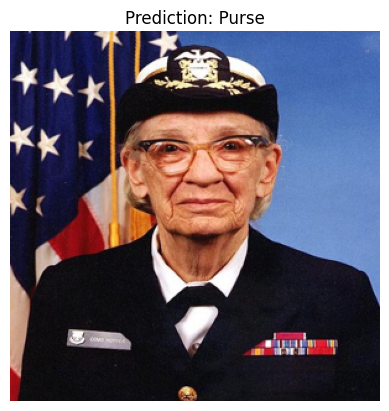

In [75]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In this example, you will use the unversity of Salford buildings dataset:

In [10]:
import pathlib
dataset_url = "https://salford.figshare.com/ndownloader/files/36524085"
data_dir = tf.keras.utils.get_file('dataset', origin=dataset_url, untar=True, cache_dir = '/content')
data_dir = pathlib.Path(data_dir)

3037144022/3037144022 ━━━━━━━━━━━━━━━━━━━━ 124s 0us/step


If you have your dataset collected by yourself, upload to your google drive and use the below code:

In [11]:
#from google.colab import drive
#drive.mount('/content/drive')
#import pathlib
#data_dir = "/content/drive/MyDrive/dataset/"
#data_dir = pathlib.Path(data_dir)

First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [12]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [13]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 751 files belonging to 1 classes.
Using 601 files for training.


In [14]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 751 files belonging to 1 classes.
Using 150 files for validation.


In [15]:
train_ds = train_dataset
val_ds = validation_dataset

See classes of the dataset:

In [16]:
class_names = np.array(train_ds.class_names)
print(class_names)

['dataset']


Note: You could also include the `tf.keras.layers.Rescaling` layer inside the model. Refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide for a discussion of the tradeoffs.

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Run the classifier on a batch of images

Now, run the classifier on an image batch:

In [95]:
result_batch = classifier.predict(train_ds)

19/19 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step


In [96]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Model T', 'Siamese cat', 'ear', 'hog', 'Dandie Dinmont',
       'maypole', 'Eskimo dog', 'Model T', 'Model T', 'Lakeland terrier',
       'Eskimo dog', 'maypole', 'ear', 'ear', 'gondola', 'Dandie Dinmont',
       'power drill', 'sleeping bag', 'Dandie Dinmont', 'otterhound',
       'fountain', 'altar', 'tank', 'envelope', 'tiger beetle',
       'red-backed sandpiper', 'sea lion', 'goblet', 'barracouta',
       'Dandie Dinmont', 'maypole', 'tank', 'toilet seat', 'bee eater',
       'Model T', 'whippet', 'Model T', 'menu', 'menu', 'gondola',
       'fountain', 'fountain', 'Dandie Dinmont', 'digital watch',
       'Dandie Dinmont', 'Model T', 'Model T', 'goblet',
       'prairie chicken', 'gondola', 'maypole', 'goblet',
       'Dandie Dinmont', 'Dandie Dinmont', 'maypole', 'ear',
       'Dandie Dinmont', 'Model T', 'dome', 'gondola', 'toilet seat',
       'ear', 'Model T', 'Model T', 'space bar', 'Dandie Dinmont',
       'crossword puzzle', 'prairie chicken', 'fountain', 'isopod',

Check how these predictions line up with the images:

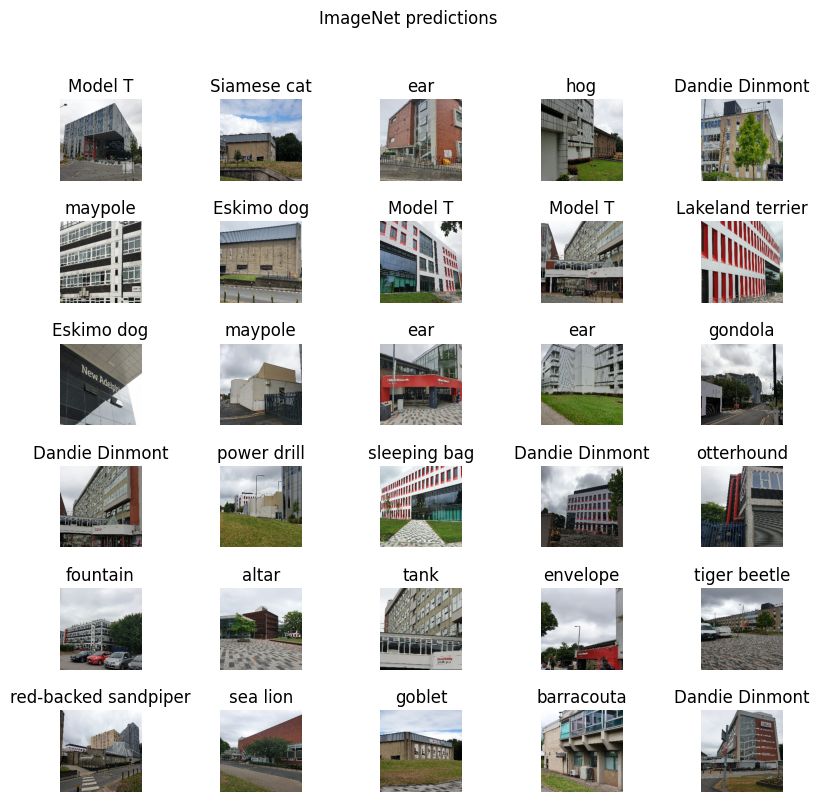

In [97]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

The results are far from perfect, but reasonable considering that these are not

### Download the Headless Model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

[TensorFlow LOAD and SAVE Model](https://www.tensorflow.org/tutorials/keras/save_and_load)

Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import datetime

Dataset Setup

In [2]:
print("🔽 Downloading dataset...")
dataset_url = "https://salford.figshare.com/ndownloader/files/36524085"
data_dir = tf.keras.utils.get_file('dataset', origin=dataset_url, untar=True, cache_dir='/content')
data_dir = pathlib.Path(data_dir)

# ✅ Auto-fix double folder structure
if (data_dir / "dataset" / "dataset").exists():
    data_dir = data_dir / "dataset" / "dataset"
elif (data_dir / "dataset").exists():
    data_dir = data_dir / "dataset"

print("✅ Using dataset directory:", data_dir)

🔽 Downloading dataset...
3037144022/3037144022 ━━━━━━━━━━━━━━━━━━━━ 191s 0us/step
✅ Using dataset directory: /content/datasets/dataset/dataset


Dataset Loading

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# ✅ Get class names
class_names = np.array(train_dataset.class_names)
print("Detected classes:", class_names)
print(f"Total number of classes: {len(class_names)}")


Found 751 files belonging to 10 classes.
Using 601 files for training.
Found 751 files belonging to 10 classes.
Using 150 files for validation.
Detected classes: ['Chapman' 'Cockcroft' 'Library' 'Maxwell' 'Media City Campus'
 'New Adelphi' 'New Science' 'Newton' 'Sports Center' 'University House']
Total number of classes: 10


Pre-Preprocessing

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_dataset.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Quick label check
for _, labels in train_ds.take(1):
    print("Unique labels in batch:", np.unique(labels.numpy()))

Unique labels in batch: [0 1 2 3 5 6 7 8 9]


Model Selection

In [5]:
print("\nChoose a base model:")
print("1️⃣  MobileNetV2")
print("2️⃣  InceptionV3")

choice = input("Enter your choice (1 or 2): ")

IMAGE_SHAPE = IMG_SIZE

if choice == "1":
    base_model = tf.keras.applications.MobileNetV2(
        weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE + (3,)
    )
elif choice == "2":
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE + (3,)
    )
else:
    print("⚠️ Invalid choice. Defaulting to MobileNetV2.")
    base_model = tf.keras.applications.MobileNetV2(
        weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE + (3,)
    )

base_model.trainable = False
print(f"✅ Using {base_model.name} as the base model")


Choose a base model:
1️⃣  MobileNetV2
2️⃣  InceptionV3
Enter your choice (1 or 2): 2
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
✅ Using inception_v3 as the base model


Model Architecture

In [6]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,066,346 (84.18 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Compile & Train

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

EPOCHS = 10
print("\n🚀 Starting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback]
)


🚀 Starting training...
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.1934 - loss: 2.5094 - val_accuracy: 0.5000 - val_loss: 1.4857
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 447ms/step - accuracy: 0.5575 - loss: 1.3655 - val_accuracy: 0.6467 - val_loss: 1.0600
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 409ms/step - accuracy: 0.6918 - loss: 0.9264 - val_accuracy: 0.7067 - val_loss: 0.8415
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step - accuracy: 0.7574 - loss: 0.7636 - val_accuracy: 0.7267 - val_loss: 0.7782
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 444ms/step - accuracy: 0.8456 - loss: 0.5515 - val_accuracy: 0.7267 - val_loss: 0.7225
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step - accuracy: 0.8732 - loss: 0.4516 - val_accuracy: 0.7533 - val_loss: 0.6521
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 452ms/step - accuracy: 0.8926 - loss: 0.4366 - val_accuracy: 0.7533 - val_loss: 0.6538
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - accuracy: 0.9073 - loss: 0.3

Visualize Training

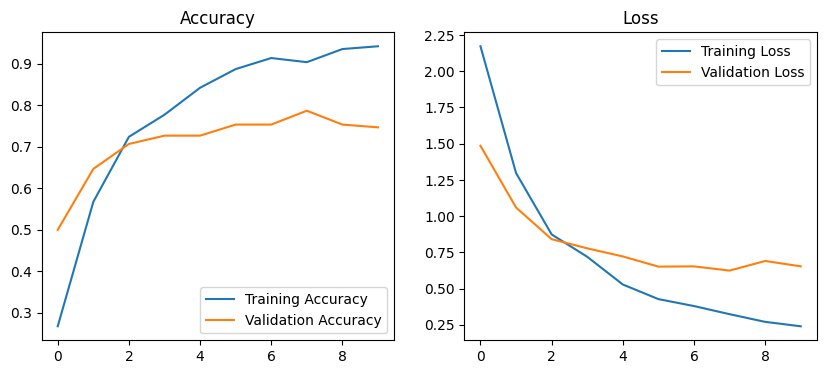

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

Save Model & Reload Saved Model

In [ ]:
save_path = "/content/salford_buildings_model.keras"
model.save(save_path)
print(f"\n✅ Model saved at: {save_path}")

print("\n♻️ Reloading saved model...")
reloaded_model = tf.keras.models.load_model(save_path)
print("✅ Model successfully reloaded.")


Predictions Visualization


🔍 Making sample predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


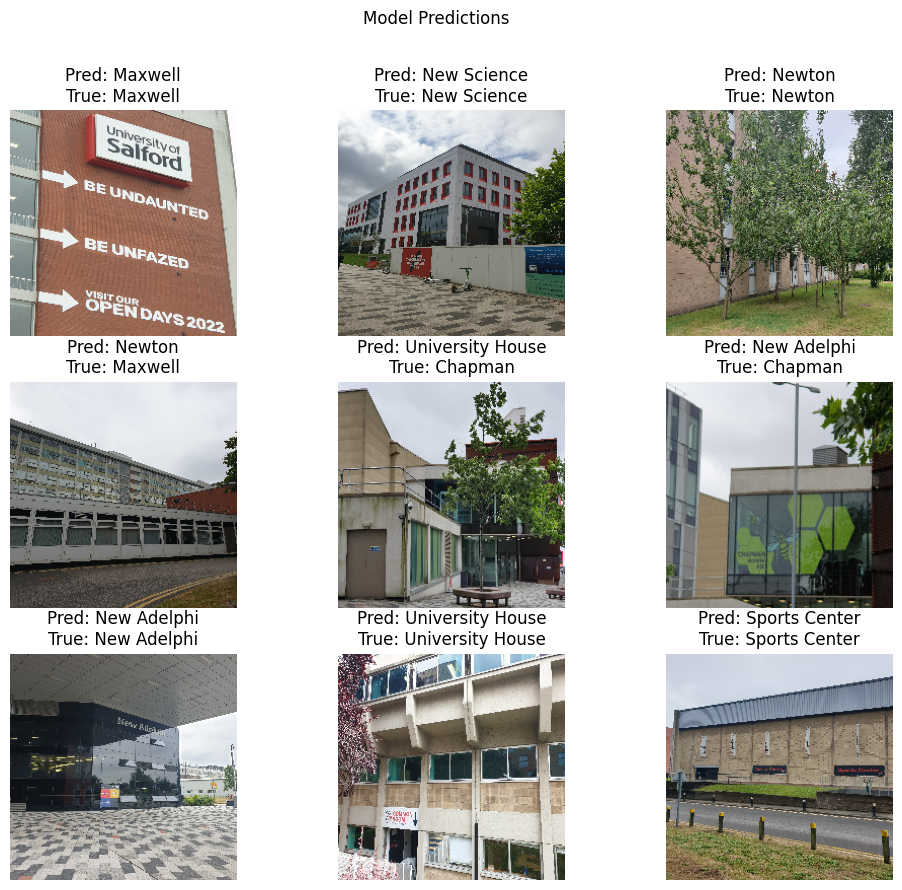

In [9]:
print("\n🔍 Making sample predictions...")
image_batch, label_batch = next(iter(val_ds))
predictions = model.predict(image_batch)
predicted_ids = tf.argmax(predictions, axis=-1)
predicted_labels = [class_names[i] for i in predicted_ids.numpy()]

plt.figure(figsize=(12, 10))
for n in range(9):
    plt.subplot(3, 3, n + 1)
    plt.imshow(image_batch[n].numpy())
    plt.title(f"Pred: {predicted_labels[n]}\nTrue: {class_names[label_batch[n]]}")
    plt.axis('off')
plt.suptitle("Model Predictions")
plt.show()